In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os
sns.set_style('whitegrid', {'axes.grid' : False})

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, \
                classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, \
                classification_report, accuracy_score, recall_score,\
                precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import  Flatten
from tensorflow.python.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Bidirectional
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

import keras
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, coding=False):
    '''This function plots the confusion matrix of the given problem'''
    import matplotlib.pyplot as plt
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=24)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    if coding:
      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2
      for i , j in itertools.product(range(cm.shape[0]),
                                     range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                   color='white' if cm[i, j] >= thresh else 'black')
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xlim(tick_marks[0]-0.5, tick_marks[len(classes)-1]+0.5)
    plt.ylim(tick_marks[0]-0.5, tick_marks[len(classes)-1]+0.5)

In [3]:
# Loading datasets
data = pd.read_csv('protein_cls.csv', index_col=0)
data.shape

(75010, 12)

In [4]:
data.head(2)

,structureId,classification,experimentalTechnique,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue,sequence,label,lengths
0,101M,oxygen transport,X-RAY DIFFRACTION,154,2.07,18112.80,3.09,60.2,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,48,154
1,102M,oxygen transport,X-RAY DIFFRACTION,154,1.84,18010.64,3.09,60.2,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,48,154


In [5]:
data = data.dropna().reset_index().drop(columns='index', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75010 entries, 0 to 75009
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   structureId               75010 non-null  object 
 1   classification            75010 non-null  object 
 2   experimentalTechnique     75010 non-null  object 
 3   residueCount              75010 non-null  int64  
 4   resolution                75010 non-null  float64
 5   structureMolecularWeight  75010 non-null  float64
 6   densityMatthews           75010 non-null  float64
 7   densityPercentSol         75010 non-null  float64
 8   phValue                   75010 non-null  float64
 9   sequence                  75010 non-null  object 
 10  label                     75010 non-null  int64  
 11  lengths                   75010 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 6.9+ MB


In [6]:
# Creating the dictionary of class and sequence counts
# Include those which has > 5000 classification frequency
classes = data.classification.value_counts()
class_d = dict()
counting = 1

for cat, num in classes.items():
    if num > 5000: # Filtering the classes for classification purpose.
        class_d[cat] = counting
    counting += 1
print("there are total {} classes on Classification variable".format(len(class_d)))
data = data[data['classification'].isin(class_d.keys())]
print("The list of the available features are: \n {} ".format(data.keys()))

there are total 4 classes on Classification variable
The list of the available features are: 
 Index(['structureId', 'classification', 'experimentalTechnique',
       'residueCount', 'resolution', 'structureMolecularWeight',
       'densityMatthews', 'densityPercentSol', 'phValue', 'sequence', 'label',
       'lengths'],
      dtype='object') 


In [7]:
data.label

6        0
8        0
9        1
23       0
24       1
        ..
74994    0
75000    0
75002    1
75003    1
75004    0
Name: label, Length: 32635, dtype: int64

In [8]:
# Separating the features and target. 

X = data[['residueCount','resolution','structureMolecularWeight','densityMatthews','densityPercentSol','phValue']]
y = data['label']

In [9]:
X.head()

,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue
6,572,2.15,65203.21,2.71,54.69,6.0
8,248,2.06,28700.28,2.48,50.36,4.8
9,420,2.30,48366.94,2.53,51.44,6.4
23,164,2.50,18562.37,2.92,57.83,8.6
24,420,1.90,48010.02,2.62,53.09,6.6


In [10]:
y.value_counts()

0    11851
1     8770
2     6885
3     5129
Name: label, dtype: int64

In [11]:
# Features are normalized with mean 0 and standard deviation 1
scaler = StandardScaler().fit(X)
X_norm =  scaler.transform(X)
X_scaled = pd.DataFrame(X_norm, columns=X.columns)
X_scaled.shape

(32635, 6)

In [12]:
X_train, X_test, y_train, y_test =train_test_split(X_scaled, y, test_size=0.3, random_state=42)

Decision Tree Classifier

In [13]:
pipe_dt = make_pipeline(SimpleImputer(), DecisionTreeClassifier(random_state = 42))
param_grid = {'decisiontreeclassifier__max_features':[1, 3, 5],\
             'decisiontreeclassifier__max_depth': [15, 20, 25]}
cv = StratifiedKFold(n_splits = 5)
gs = GridSearchCV(estimator = pipe_dt, param_grid = param_grid, scoring = 'accuracy',\
                 cv = cv, return_train_score = True)
gs.fit(X_scaled, y)
max_depth_best = gs.best_params_["decisiontreeclassifier__max_depth"]
max_features_best = gs.best_params_["decisiontreeclassifier__max_features"]

In [14]:
dt = DecisionTreeClassifier(max_depth = max_depth_best, max_features = max_features_best, random_state = 42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
ac = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, average="weighted")
pre = precision_score(y_test, y_pred, average="weighted")

print('Decision Tree Classifier: Accuracy=%.3f' % (ac))
print('Decision Tree Classifier: Recall=%.3f' % (rec))
print('Decision Tree Classifier: Precision=%.3f' % (pre))

Decision Tree Classifier: Accuracy=0.563
Decision Tree Classifier: Recall=0.563
Decision Tree Classifier: Precision=0.565


In [15]:
print("classification report: \n {} ".format(classification_report(y_test, y_pred)))

classification report: 
               precision    recall  f1-score   support

           0       0.56      0.65      0.60      3566
           1       0.51      0.52      0.52      2654
           2       0.56      0.42      0.48      2084
           3       0.67      0.61      0.64      1487

    accuracy                           0.56      9791
   macro avg       0.58      0.55      0.56      9791
weighted avg       0.57      0.56      0.56      9791
 


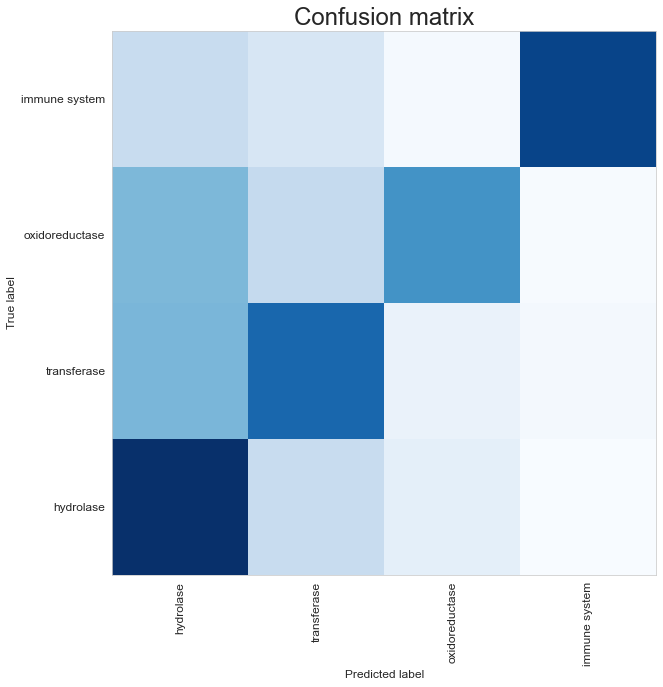

In [16]:
# Plotting the confusion matrix for classification:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_d)

Random Forest

In [17]:
pipe_rf = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state = 42))
param_grid = {'randomforestclassifier__n_estimators':[50, 100, 150],\
             'randomforestclassifier__max_depth': [20, 25, 30]}
cv = StratifiedKFold(n_splits = 5)
gs = GridSearchCV(estimator = pipe_rf, param_grid = param_grid, scoring = 'accuracy',\
                 cv = cv, return_train_score = True)
gs.fit(X_scaled, y)
max_depth_best = gs.best_params_["randomforestclassifier__max_depth"]
n_estimators_best = gs.best_params_["randomforestclassifier__n_estimators"]

In [18]:
print("best Parameters: \n {} \n".format(gs.best_params_))

best Parameters: 
 {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 150} 



In [19]:
rf = RandomForestClassifier(max_depth = max_depth_best, n_estimators = n_estimators_best, random_state = 42)
rf.fit(X_train, y_train)
estimator = rf.estimators_[5]
y_pred = rf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, average="weighted")
pre = precision_score(y_test, y_pred, average='weighted')

print('RandomForestClassifier: Accuracy=%.3f' % (ac))
print('RandomForestClassifier: Recall=%.3f' % (rec))
print('RandomForestClassifier: Precision=%.3f' % (pre))

RandomForestClassifier: Accuracy=0.646
RandomForestClassifier: Recall=0.646
RandomForestClassifier: Precision=0.648


In [20]:
print("classification report: \n {}".format(classification_report(y_test, y_pred)))

classification report: 
               precision    recall  f1-score   support

           0       0.62      0.73      0.67      3566
           1       0.61      0.57      0.59      2654
           2       0.66      0.51      0.57      2084
           3       0.78      0.78      0.78      1487

    accuracy                           0.65      9791
   macro avg       0.67      0.65      0.65      9791
weighted avg       0.65      0.65      0.64      9791



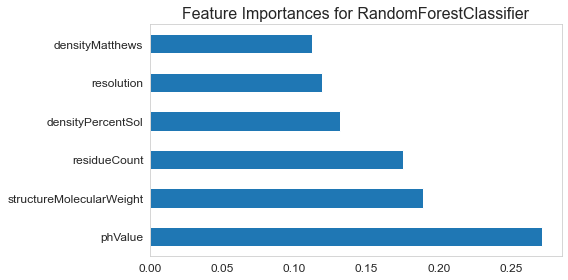

In [21]:
feat_importances = pd.Series(rf.feature_importances_,
                             index=X_train.columns)
import os
fig, ax = plt.subplots(figsize=(8, 4))
feat_importances.nlargest(15).plot(kind='barh', ax=ax, fontsize=12)
plt.title('Feature Importances for RandomForestClassifier', fontsize=16)
plt.tight_layout()

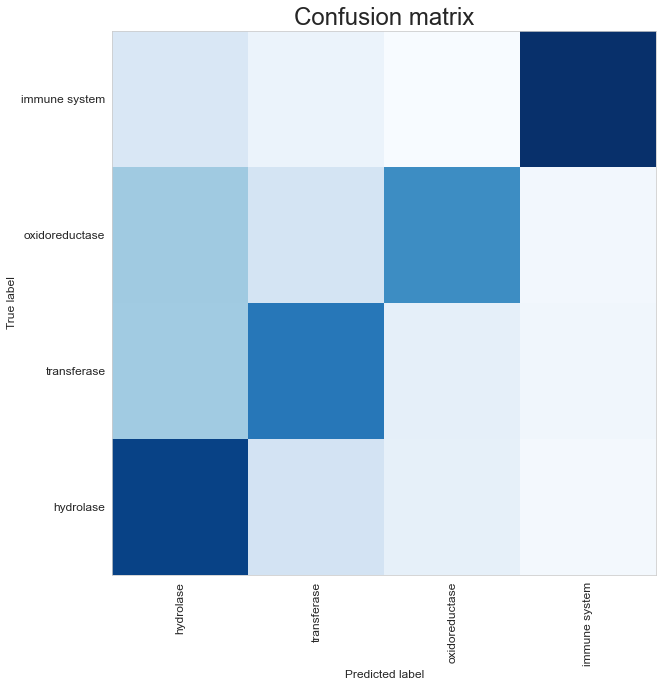

In [22]:
# Plotting the confusion matrix for classification:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_d)

KNN

In [23]:
pipe_knn = make_pipeline(SimpleImputer(), KNeighborsClassifier())
param_grid = {'kneighborsclassifier__n_neighbors':[3,5,7,9]}
cv = StratifiedKFold(n_splits = 5)
gs = GridSearchCV(estimator = pipe_knn, param_grid = param_grid, scoring = 'accuracy',\
                 cv = cv, return_train_score = True)
gs.fit(X_scaled, y)
n_neighbors_best = gs.best_params_["kneighborsclassifier__n_neighbors"]

In [24]:
n_neighbors_best

9

In [25]:
knn = KNeighborsClassifier(n_neighbors = n_neighbors_best)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
ac = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, average = "weighted")
pre = precision_score(y_test, y_pred, average = "weighted")

print('KNN Classifier: Accuracy=%.3f' % (ac))
print('KNN Classifier: Recall=%.3f' % (rec))
print('KNN: Precision=%.3f' % (pre))

KNN Classifier: Accuracy=0.431
KNN Classifier: Recall=0.431
KNN: Precision=0.425


In [26]:
print("classification report: \n {}".format(classification_report(y_test, y_pred)))

classification report: 
               precision    recall  f1-score   support

           0       0.46      0.61      0.52      3566
           1       0.40      0.37      0.38      2654
           2       0.40      0.27      0.32      2084
           3       0.43      0.33      0.38      1487

    accuracy                           0.43      9791
   macro avg       0.42      0.40      0.40      9791
weighted avg       0.42      0.43      0.42      9791



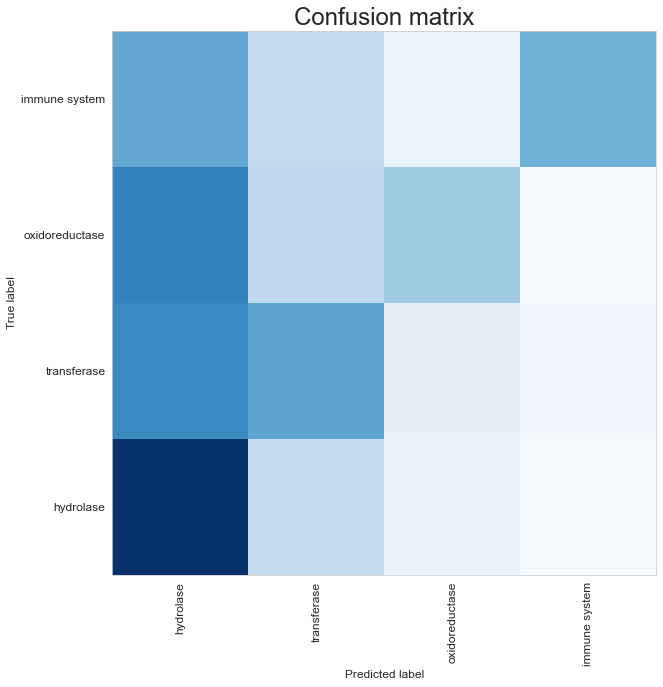

In [27]:
# Plotting the confusion matrix for classification:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_d)

Part II: Deep Learning:


In [28]:
data = pd.read_csv('protein_seq-cls.csv',index_col=0)
data.drop_duplicates(subset='sequence', inplace=True)
data.shape

(74834, 5)

In [29]:
data.head()

,structureId,classification,sequence,lengths,label
0,101M,oxygen transport,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,48
1,102M,oxygen transport,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,48
2,104M,oxygen transport,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,153,48
3,106M,oxygen transport,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,48
4,109M,oxygen transport,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,48


In [30]:
# Creating the dictionary of class and sequence counts
# Include those which has > 1200 classification frequency
classes = data.classification.value_counts()
class_d = dict()
counting = 1

for cat, num in classes.items():
    if num > 1200: # Filtering the classes for classification purpose.
        class_d[cat] = counting
        counting += 1
print("there are total {} classes on Classification variable".format(len(class_d)))
data = data[data['classification'].isin(class_d.keys())]
print("The list of the available features are: \n {} ".format(data.keys()))

there are total 15 classes on Classification variable
The list of the available features are: 
 Index(['structureId', 'classification', 'sequence', 'lengths', 'label'], dtype='object') 


In [31]:
# Constructing the dictionary of protein superfamily classes and 
# total number of samples belonging to those classes
classes = data.classification.value_counts()
class_d = dict()
counting = 0
contents = 1200 # Disregard the samples belonging to the 
                # family with total members less than 'contents'

for cat, num in classes.items():
    if num > contents:
      counting += 1
      class_d[cat] = counting

class_dim = len(class_d)
print('Total classes: ', class_dim)

Total classes:  15


In [32]:
class_d.items()

dict_items([('hydrolase', 1), ('transferase', 2), ('oxidoreductase', 3), ('immune system', 4), ('transcription', 5), ('lyase', 6), ('signaling protein', 7), ('structural genomics/unknown function', 8), ('transport protein', 9), ('protein binding', 10), ('viral protein', 11), ('isomerase', 12), ('hydrolase/hydrolase inhibitor', 13), ('ligase', 14), ('membrane protein', 15)])

In [33]:
data.head()

,structureId,classification,sequence,lengths,label
6,117E,hydrolase,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,286,0
7,11AS,ligase,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,330,13
8,11BA,hydrolase,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,124,0
9,11GS,transferase,MPPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKA...,210,1
23,177L,hydrolase,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,164,0


In [34]:
# List the selected classes:
top_classes = class_d.keys()
print('Total Classes: ', len(top_classes),
      '\nClasses:\n ', np.array(list(top_classes)))

Total Classes:  15 
Classes:
  ['hydrolase' 'transferase' 'oxidoreductase' 'immune system'
 'transcription' 'lyase' 'signaling protein'
 'structural genomics/unknown function' 'transport protein'
 'protein binding' 'viral protein' 'isomerase'
 'hydrolase/hydrolase inhibitor' 'ligase' 'membrane protein']


In [35]:
t_vectorizer = TfidfVectorizer(analyzer='char',
                               ngram_range=(3,3),
                               max_features=5000,
                               sublinear_tf=True)
X = t_vectorizer.fit_transform(data['sequence'].values)
y = to_categorical(data['label'])

In [36]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [37]:
# Transform labels to one-hot
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
Y1 = lb.fit_transform(data.classification)

In [38]:
data.classification

6                            hydrolase
7                               ligase
8                            hydrolase
9                          transferase
23                           hydrolase
                     ...              
75194                      transferase
75195                      transferase
75196                        hydrolase
75197    hydrolase/hydrolase inhibitor
75198    hydrolase/hydrolase inhibitor
Name: classification, Length: 53623, dtype: object

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 22)
X_train = X_train.toarray()
X_test = X_test.toarray()

print('Shape of X_train: {}'.format(np.shape(X_train)))
print('Shape of y_train: {}'.format(np.shape(y_train)))
print('Shape of X_test: {}'.format(np.shape(X_test)))
print('Shape of y_test: {}'.format(np.shape(y_test)))

Shape of X_train: (40217, 5000)
Shape of y_train: (40217, 15)
Shape of X_test: (13406, 5000)
Shape of y_test: (13406, 15)


In [40]:
X_train1 = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test1 = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train1.shape, X_test1.shape)

(40217, 1, 5000) (13406, 1, 5000)


In [41]:
input_shape = (X_train1.shape[1:])
print(input_shape)

(1, 5000)


LSTM

In [42]:
tf.random.set_seed(99) ### to reproduce the same result

model = Sequential()
model.add(LSTM(256, input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences = False))
model.add(Dense(len(class_d), activation='softmax'))
model.compile(optimizer='adamax',loss='categorical_crossentropy',\
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC()])

#early_stopping_monitors = EarlyStopping(patience = 7)
history = model.fit(X_train1,y_train,epochs=100,validation_data=(X_test1, y_test), batch_size = 50)
model.summary()

Epoch 1/100
805/805 [==============================] - 25s 31ms/step - loss: 2.2418 - accuracy: 0.2618 - recall: 0.0274 - precision: 0.9298 - auc: 0.7736 - val_loss: 2.0872 - val_accuracy: 0.2837 - val_recall: 0.0692 - val_precision: 0.9299 - val_auc: 0.8134
Epoch 2/100
805/805 [==============================] - 23s 29ms/step - loss: 1.9419 - accuracy: 0.3436 - recall: 0.1329 - precision: 0.8147 - auc: 0.8404 - val_loss: 1.9487 - val_accuracy: 0.3562 - val_recall: 0.1731 - val_precision: 0.7260 - val_auc: 0.8378
Epoch 3/100
805/805 [==============================] - 25s 31ms/step - loss: 1.8016 - accuracy: 0.4073 - recall: 0.2060 - precision: 0.7942 - auc: 0.8630 - val_loss: 1.9009 - val_accuracy: 0.3879 - val_recall: 0.2154 - val_precision: 0.7049 - val_auc: 0.8466
Epoch 4/100
805/805 [==============================] - 26s 32ms/step - loss: 1.6960 - accuracy: 0.4508 - recall: 0.2690 - precision: 0.8029 - auc: 0.8786 - val_loss: 1.7954 - val_accuracy: 0.4384 - val_recall: 0.2723 - val_

805/805 [==============================] - 26s 32ms/step - loss: 0.5475 - accuracy: 0.8285 - recall: 0.7736 - precision: 0.9082 - auc: 0.9860 - val_loss: 2.2748 - val_accuracy: 0.5756 - val_recall: 0.5331 - val_precision: 0.6454 - val_auc: 0.8627
Epoch 33/100
805/805 [==============================] - 28s 35ms/step - loss: 0.5246 - accuracy: 0.8363 - recall: 0.7809 - precision: 0.9122 - auc: 0.9870 - val_loss: 2.3112 - val_accuracy: 0.5747 - val_recall: 0.5352 - val_precision: 0.6447 - val_auc: 0.8617
Epoch 34/100
805/805 [==============================] - 27s 33ms/step - loss: 0.5000 - accuracy: 0.8441 - recall: 0.7926 - precision: 0.9154 - auc: 0.9879 - val_loss: 2.3669 - val_accuracy: 0.5758 - val_recall: 0.5392 - val_precision: 0.6407 - val_auc: 0.8609
Epoch 35/100
805/805 [==============================] - 29s 36ms/step - loss: 0.4807 - accuracy: 0.8496 - recall: 0.8021 - precision: 0.9172 - auc: 0.9888 - val_loss: 2.4222 - val_accuracy: 0.5780 - val_recall: 0.5417 - val_precision

805/805 [==============================] - 35s 43ms/step - loss: 0.1790 - accuracy: 0.9429 - recall: 0.9318 - precision: 0.9579 - auc: 0.9978 - val_loss: 3.5118 - val_accuracy: 0.5894 - val_recall: 0.5789 - val_precision: 0.6126 - val_auc: 0.8404
Epoch 64/100
805/805 [==============================] - 32s 39ms/step - loss: 0.1779 - accuracy: 0.9432 - recall: 0.9314 - precision: 0.9568 - auc: 0.9979 - val_loss: 3.5058 - val_accuracy: 0.5922 - val_recall: 0.5818 - val_precision: 0.6132 - val_auc: 0.8407
Epoch 65/100
805/805 [==============================] - 31s 38ms/step - loss: 0.1733 - accuracy: 0.9444 - recall: 0.9332 - precision: 0.9577 - auc: 0.9980 - val_loss: 3.5410 - val_accuracy: 0.5912 - val_recall: 0.5817 - val_precision: 0.6119 - val_auc: 0.8402
Epoch 66/100
805/805 [==============================] - 32s 40ms/step - loss: 0.1705 - accuracy: 0.9457 - recall: 0.9349 - precision: 0.9584 - auc: 0.9978 - val_loss: 3.5549 - val_accuracy: 0.5932 - val_recall: 0.5818 - val_precision

805/805 [==============================] - 28s 35ms/step - loss: 0.0988 - accuracy: 0.9666 - recall: 0.9624 - precision: 0.9713 - auc: 0.9991 - val_loss: 4.1151 - val_accuracy: 0.5922 - val_recall: 0.5855 - val_precision: 0.6054 - val_auc: 0.8334
Epoch 95/100
805/805 [==============================] - 29s 37ms/step - loss: 0.1009 - accuracy: 0.9659 - recall: 0.9622 - precision: 0.9703 - auc: 0.9990 - val_loss: 4.0253 - val_accuracy: 0.5970 - val_recall: 0.5891 - val_precision: 0.6099 - val_auc: 0.8347
Epoch 96/100
805/805 [==============================] - 28s 34ms/step - loss: 0.0959 - accuracy: 0.9682 - recall: 0.9637 - precision: 0.9725 - auc: 0.9992 - val_loss: 4.0755 - val_accuracy: 0.5965 - val_recall: 0.5894 - val_precision: 0.6100 - val_auc: 0.8345
Epoch 97/100
805/805 [==============================] - 28s 35ms/step - loss: 0.0926 - accuracy: 0.9687 - recall: 0.9646 - precision: 0.9724 - auc: 0.9993 - val_loss: 4.1256 - val_accuracy: 0.5941 - val_recall: 0.5891 - val_precision

In [43]:
tmp = model.evaluate(X_test1, y_test)
print()
print("Accuracy: {:.2f}".format(tmp[1]))
print("Recall: {:.2f}".format(tmp[2]))
print("Precision: {:.2f}".format(tmp[3]))
print("AUC: {:.2f}".format(tmp[4]))

419/419 [==============================] - 3s 8ms/step - loss: 4.1063 - accuracy: 0.5944 - recall: 0.5885 - precision: 0.6080 - auc: 0.8343

Accuracy: 0.59
Recall: 0.59
Precision: 0.61
AUC: 0.83


In [44]:
def plot_confusion_matrix(c1, c2, family,
                          filename,
                          normalize=False):
    if normalize:
        c1 = c1.astype('float') / c1.sum(axis=1)[:, np.newaxis]
        c2 = c2.astype('float') / c2.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.imshow(c1, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix\nTrain Set', fontsize=20)
    tick_marks = np.arange(len(family))
    plt.xticks(tick_marks, family, rotation=90, fontsize=15)
    plt.yticks(tick_marks, family, fontsize=15)
    plt.grid(False)
    
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xlim(tick_marks[0]-0.5, tick_marks[len(family)-1]+0.5)
    plt.ylim(tick_marks[0]-0.5, tick_marks[len(family)-1]+0.5)
    

    plt.subplot(1, 2, 2)
    plt.imshow(c2, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix\nTest Set', fontsize=20)
    tick_marks = np.arange(len(family))
    plt.xticks(tick_marks, family, rotation=90, fontsize=15)
    plt.yticks(tick_marks, family, fontsize=15)
    
    #fmt = '.2f' if normalize else 'd'
    #thresh = c2.max() / 2
    
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xlim(tick_marks[0]-0.5, tick_marks[len(family)-1]+0.5)
    plt.ylim(tick_marks[0]-0.5, tick_marks[len(family)-1]+0.5)
    plt.colorbar(fraction=0.048, pad=0.05)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(filename)
    
def plot_history(history):
    import matplotlib.pyplot as plt
    import os
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc', marker='o')
    plt.plot(x, val_acc, 'r', label='Validation acc', marker='s')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss', marker='o')
    plt.plot(x, val_loss, 'r', label='Validation loss', marker='s')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig(os.path.join(path_to_data, 'loss-acc.pdf'))

In [45]:
train_pred = model.predict(X_train1)
test_pred = model.predict(X_test1)
print('train-acc = ' + str(accuracy_score(np.argmax(y_train, axis=1),
                                          np.argmax(train_pred, axis=1))))
print('test-acc = ' + str(accuracy_score(np.argmax(y_test, axis=1),
                                         np.argmax(test_pred, axis=1))))
# Compute confusion matrix
cm_train = confusion_matrix(np.argmax(y_train, axis=1),
                            np.argmax(train_pred, axis=1))
cm_test = confusion_matrix(np.argmax(y_test, axis=1),
                           np.argmax(test_pred, axis=1))

np.set_printoptions(precision=2)

train-acc = 0.981674416291618
test-acc = 0.5943607339997016


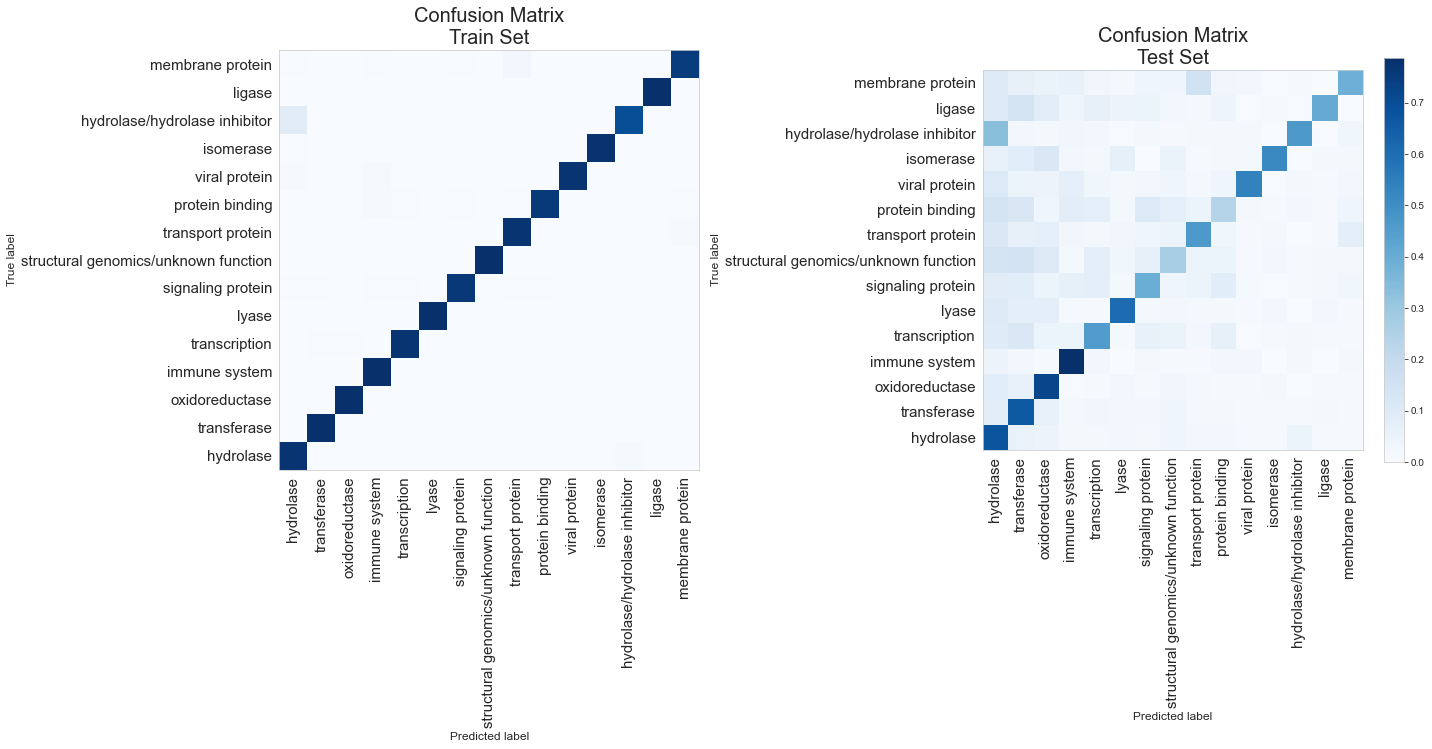

In [46]:

path_to_data = "./"
saving_as = os.path.join(path_to_data, 'confusion_matrix_LSTM.pdf')
plot_confusion_matrix(cm_train, cm_test, class_d, saving_as, normalize=True)

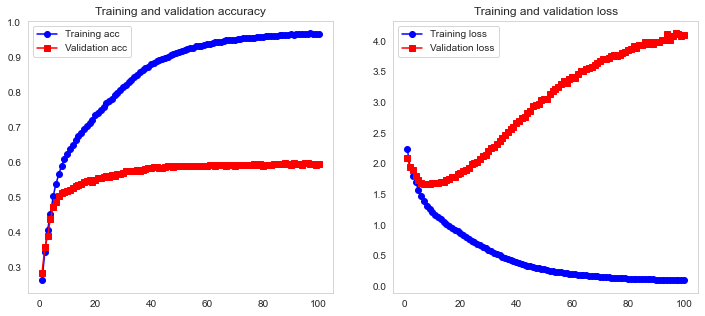

In [47]:
plot_history(history)

BiDirectional LSTM

In [48]:
tf.random.set_seed(99) ### to reproduce the same result

model1 = Sequential()
model1.add(Bidirectional(LSTM(256, input_shape=input_shape, return_sequences=True)))
model1.add(Dropout(0.2))
model1.add(Bidirectional(LSTM(256, return_sequences = True)))
model1.add(Dropout(0.2))
model1.add(Bidirectional(LSTM(256, return_sequences = False)))
model1.add(Dense(len(class_d), activation='softmax'))
model1.compile(optimizer='adamax',loss='categorical_crossentropy',\
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC()])

#early_stopping_monitors = EarlyStopping(patience = 7)
history1 = model1.fit(X_train1,y_train,epochs=100,validation_data=(X_test1, y_test), batch_size = 50)
model1.summary()

Epoch 1/100
805/805 [==============================] - 54s 68ms/step - loss: 2.0957 - accuracy: 0.3152 - recall_1: 0.0909 - precision_1: 0.8264 - auc_1: 0.8061 - val_loss: 1.9181 - val_accuracy: 0.3852 - val_recall_1: 0.1789 - val_precision_1: 0.8097 - val_auc_1: 0.8401
Epoch 2/100
805/805 [==============================] - 52s 65ms/step - loss: 1.7299 - accuracy: 0.4470 - recall_1: 0.2705 - precision_1: 0.8009 - auc_1: 0.8722 - val_loss: 1.7733 - val_accuracy: 0.4446 - val_recall_1: 0.2919 - val_precision_1: 0.7355 - val_auc_1: 0.8655
Epoch 3/100
805/805 [==============================] - 54s 67ms/step - loss: 1.5622 - accuracy: 0.5075 - recall_1: 0.3403 - precision_1: 0.8060 - auc_1: 0.8972 - val_loss: 1.7272 - val_accuracy: 0.4723 - val_recall_1: 0.3213 - val_precision_1: 0.7430 - val_auc_1: 0.8730
Epoch 4/100
805/805 [==============================] - 53s 66ms/step - loss: 1.4597 - accuracy: 0.5425 - recall_1: 0.3789 - precision_1: 0.8131 - auc_1: 0.9110 - val_loss: 1.6667 - val_ac

805/805 [==============================] - 55s 68ms/step - loss: 0.2825 - accuracy: 0.9129 - recall_1: 0.8894 - precision_1: 0.9404 - auc_1: 0.9950 - val_loss: 3.0767 - val_accuracy: 0.5847 - val_recall_1: 0.5677 - val_precision_1: 0.6162 - val_auc_1: 0.8490
Epoch 32/100
805/805 [==============================] - 56s 69ms/step - loss: 0.2679 - accuracy: 0.9165 - recall_1: 0.8949 - precision_1: 0.9413 - auc_1: 0.9955 - val_loss: 3.1222 - val_accuracy: 0.5854 - val_recall_1: 0.5686 - val_precision_1: 0.6144 - val_auc_1: 0.8480
Epoch 33/100
805/805 [==============================] - 56s 69ms/step - loss: 0.2529 - accuracy: 0.9227 - recall_1: 0.9032 - precision_1: 0.9451 - auc_1: 0.9959 - val_loss: 3.1922 - val_accuracy: 0.5853 - val_recall_1: 0.5699 - val_precision_1: 0.6146 - val_auc_1: 0.8465
Epoch 34/100
805/805 [==============================] - 56s 69ms/step - loss: 0.2418 - accuracy: 0.9262 - recall_1: 0.9070 - precision_1: 0.9468 - auc_1: 0.9962 - val_loss: 3.2615 - val_accuracy: 0

805/805 [==============================] - 55s 69ms/step - loss: 0.0998 - accuracy: 0.9669 - recall_1: 0.9635 - precision_1: 0.9702 - auc_1: 0.9992 - val_loss: 4.1916 - val_accuracy: 0.5878 - val_recall_1: 0.5809 - val_precision_1: 0.5992 - val_auc_1: 0.8308
Epoch 62/100
805/805 [==============================] - 56s 69ms/step - loss: 0.0955 - accuracy: 0.9671 - recall_1: 0.9643 - precision_1: 0.9706 - auc_1: 0.9992 - val_loss: 4.2746 - val_accuracy: 0.5896 - val_recall_1: 0.5834 - val_precision_1: 0.6006 - val_auc_1: 0.8300
Epoch 63/100
805/805 [==============================] - 55s 69ms/step - loss: 0.0957 - accuracy: 0.9681 - recall_1: 0.9654 - precision_1: 0.9717 - auc_1: 0.9991 - val_loss: 4.2999 - val_accuracy: 0.5874 - val_recall_1: 0.5806 - val_precision_1: 0.5998 - val_auc_1: 0.8304
Epoch 64/100
805/805 [==============================] - 55s 69ms/step - loss: 0.0914 - accuracy: 0.9684 - recall_1: 0.9660 - precision_1: 0.9716 - auc_1: 0.9993 - val_loss: 4.2810 - val_accuracy: 0

805/805 [==============================] - 56s 69ms/step - loss: 0.0615 - accuracy: 0.9777 - recall_1: 0.9763 - precision_1: 0.9793 - auc_1: 0.9997 - val_loss: 4.7119 - val_accuracy: 0.5898 - val_recall_1: 0.5852 - val_precision_1: 0.5996 - val_auc_1: 0.8268
Epoch 92/100
805/805 [==============================] - 56s 69ms/step - loss: 0.0624 - accuracy: 0.9778 - recall_1: 0.9762 - precision_1: 0.9799 - auc_1: 0.9997 - val_loss: 4.7427 - val_accuracy: 0.5915 - val_recall_1: 0.5869 - val_precision_1: 0.6001 - val_auc_1: 0.8268
Epoch 93/100
805/805 [==============================] - 56s 69ms/step - loss: 0.0612 - accuracy: 0.9776 - recall_1: 0.9764 - precision_1: 0.9794 - auc_1: 0.9997 - val_loss: 4.7339 - val_accuracy: 0.5905 - val_recall_1: 0.5867 - val_precision_1: 0.5991 - val_auc_1: 0.8261
Epoch 94/100
805/805 [==============================] - 56s 69ms/step - loss: 0.0598 - accuracy: 0.9786 - recall_1: 0.9771 - precision_1: 0.9802 - auc_1: 0.9997 - val_loss: 4.7740 - val_accuracy: 0

In [49]:
tmp1 = model1.evaluate(X_test1, y_test)
print()
print("Accuracy: {:.2f}".format(tmp1[1]))
print("Recall: {:.2f}".format(tmp1[2]))
print("Precision: {:.2f}".format(tmp1[3]))
print("AUC: {:.2f}".format(tmp1[4]))

419/419 [==============================] - 6s 15ms/step - loss: 4.8214 - accuracy: 0.5920 - recall_1: 0.5883 - precision_1: 0.5996 - auc_1: 0.8260

Accuracy: 0.59
Recall: 0.59
Precision: 0.60
AUC: 0.83


In [50]:
train_pred1 = model1.predict(X_train1)
test_pred1 = model1.predict(X_test1)
print('train-acc = ' + str(accuracy_score(np.argmax(y_train, axis=1),
                                          np.argmax(train_pred1, axis=1))))
print('test-acc = ' + str(accuracy_score(np.argmax(y_test, axis=1),
                                         np.argmax(test_pred1, axis=1))))
# Compute confusion matrix
cm_train1 = confusion_matrix(np.argmax(y_train, axis=1),
                            np.argmax(train_pred1, axis=1))
cm_test1 = confusion_matrix(np.argmax(y_test, axis=1),
                           np.argmax(test_pred1, axis=1))

np.set_printoptions(precision=2)

train-acc = 0.9880896138448915
test-acc = 0.5920483365657169


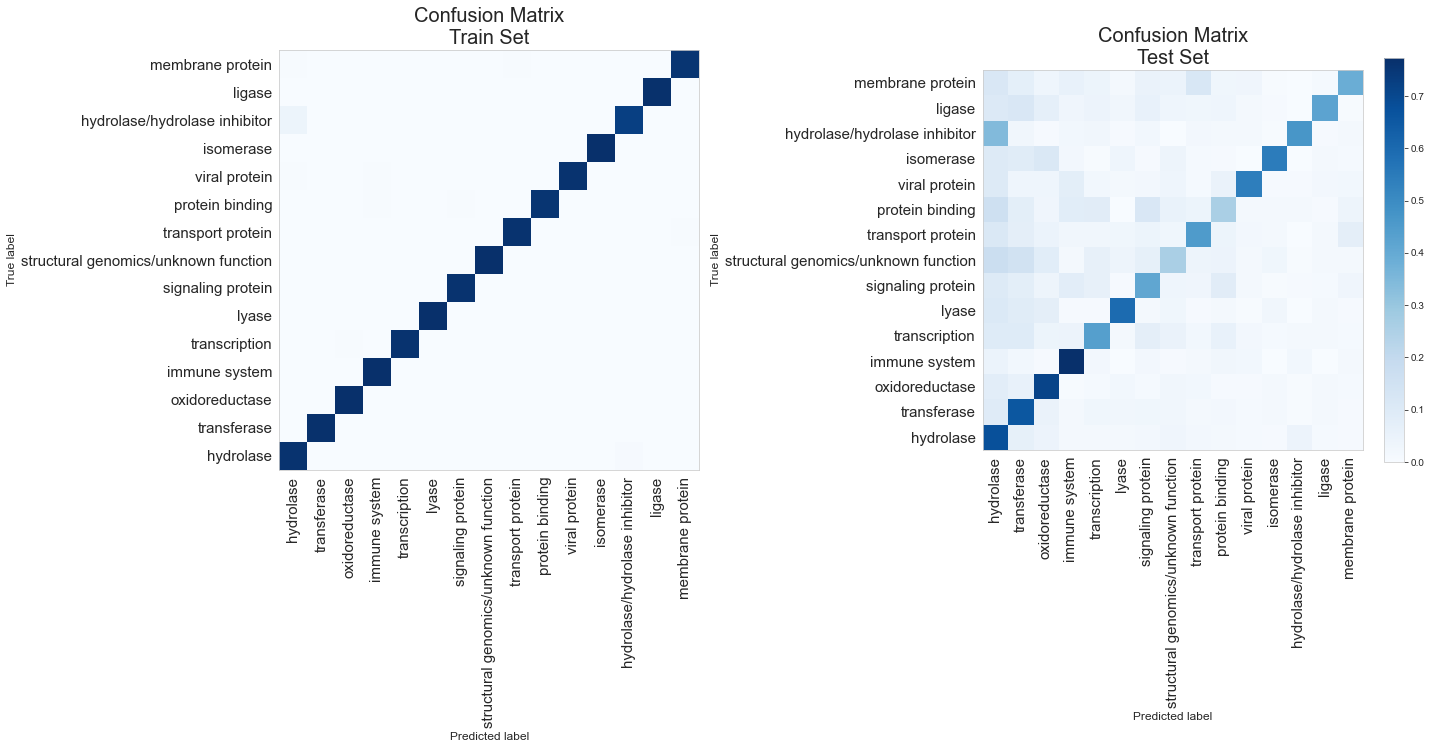

In [51]:
path_to_data = "./"
saving_as = os.path.join(path_to_data, 'confusion_matrix_BiLSTM.pdf')
plot_confusion_matrix(cm_train1, cm_test1, class_d, saving_as, normalize=True)

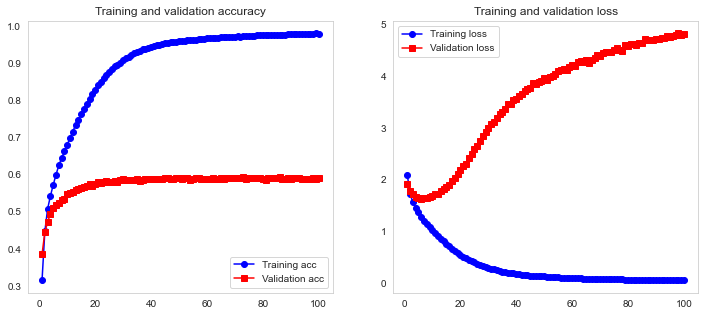

In [52]:
plot_history(history1)